In [1]:
import sys
sys.path.append('..')
from NCA.trainer.NCA_trainer import NCA_Trainer
from Common.utils import load_emoji_sequence
from Common.eddie_indexer import index_to_data_nca_type
from NCA.trainer.data_augmenter_nca import DataAugmenter
from NCA.model.NCA_model import NCA
from einops import rearrange,repeat
import time
import jax
import jax.numpy as np
import optax
import matplotlib.pyplot as plt

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alex/.netrc
wandb: Currently logged in as: alexander-richardson (alexander-richardson-university-of-edinburgh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
CHANNELS = 32           # How many channels to use in the model
TRAINING_STEPS = 1000   # How many steps to train for
DOWNSAMPLE = 4          # How much to downsample the image by
NCA_STEPS = 48          # How many NCA steps between each image in the data sequence

In [3]:
model = NCA(N_CHANNELS=CHANNELS,
            KERNEL_STR=["ID","GRAD","LAP"],
            ACTIVATION=jax.nn.relu,
            PADDING="CIRCULAR",
            FIRE_RATE=0.5)

(1, 4, 4, 30, 30)
(4, 1, 4, 30, 30)
(8, 1, 4, 30, 30)
(Batch, Time, Channels, Width, Height): (8, 3, 4, 30, 30)


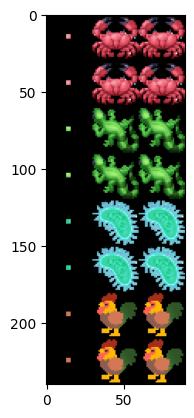

(240, 90, 3)


In [4]:
data = load_emoji_sequence(["crab.png","lizard.png","microbe.png","rooster.png"],impath_emojis="demo_data/",downsample=DOWNSAMPLE)


# For the initial condition, take a small cropped square from the middle of the target image
print(data.shape)
data = rearrange(data,"B T C W H -> T B C W H")
print(data.shape)
data = repeat(data,"B T C W H -> (B b) T C W H",b=2)
print(data.shape)
initial_condition = np.array(data)


W = initial_condition.shape[-2]
H = initial_condition.shape[-1]

initial_condition = initial_condition.at[:,:,:,:W//2-2].set(0)
initial_condition = initial_condition.at[:,:,:,W//2+1:].set(0)
initial_condition = initial_condition.at[:,:,:,:,:H//2-2].set(0)
initial_condition = initial_condition.at[:,:,:,:,H//2+1:].set(0)


data = np.concatenate([initial_condition,data,data],axis=1) # Join initial condition and data along the time axis

print("(Batch, Time, Channels, Width, Height): "+str(data.shape))

plt.imshow(rearrange(data,"B T C W H -> (B W) (T H) C" )[...,:3])
plt.show()
print(rearrange(data,"B T C W H -> (B W) (T H) C" )[...,:3].shape)

class data_augmenter_subclass(DataAugmenter):
    #Redefine how data is pre-processed before training
    def data_init(self,SHARDING=None):
        data = self.return_saved_data()
        data = self.duplicate_batches(data, 1)
        data = self.pad(data, 10) 		
        self.save_data(data)
        return None
    

In [5]:
trainer = NCA_Trainer(NCA_model=model,
                      data = data,
                      DATA_AUGMENTER=data_augmenter_subclass,
                      model_filename="multi_species_stable",
                      MODEL_DIRECTORY="demo/models",
                      
                      )

Batches = 8


In [6]:
schedule = optax.exponential_decay(1e-3, transition_steps=TRAINING_STEPS, decay_rate=0.99)
optimiser = optax.chain(optax.scale_by_param_block_norm(),
                        optax.nadam(schedule))


trainer.train(t=NCA_STEPS,iters=TRAINING_STEPS,LOOP_AUTODIFF="lax",optimiser=optimiser)

Raw data shape: (8, 3, 4, 30, 30)


(240, 90, 3)
Logging training to: logs/multi_species_stable/train
Saving model to: demo/modelsmulti_species_stable


  0%|          | 0/1000 [00:27<?, ?it/s, loss=0.10964141, best loss=1e+8, loss diff=-100000000.0]

(2, 500, 4)
(4, 500, 4)


  0%|          | 1/1000 [00:34<9:38:43, 34.76s/it, loss=0.10964141, best loss=1e+8, loss diff=-100000000.0]wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 1. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the curre

KeyboardInterrupt: 